In [1]:
import healpy as hp
import numpy as np
import pylab as pl 
maps= hp.read_map('../outputs/bfit_maps_hp.fits', field=None ) 
print(maps.shape)
beta =maps[0]
cs = maps[1]
nans = np.ma.masked_invalid(beta).mask 
beta [nans] = 0.0
cs[nans] = 0.0

#hp.write_map('../outputs/common_footprint.fits', np.logical_not(nans) , overwrite=True)


apo = hp.read_map('../outputs/common_footprint_apo.fits', field=0 )



(4, 786432)


In [2]:
nside=hp.get_nside(beta)  # Get the nside parameter from the map 
# Assume 'healpix_map' is your input map (numpy array)
# Estimate alm coefficients up to lmax
lmax = 3*nside-1   # or set as desired
alm = hp.map2alm(beta*apo , lmax=lmax)

# Create a large scale filter using a sigmoid function
def sigmoid_filter(l, l0=50, width=5):
    """Sigmoid filter centered at l0 with given width."""
    a =   1 / (1 + np.exp((- l0) / width))
    return 1 /a /(1 + np.exp((l - l0) / width))
 
# Raised cosine (tapered) filter to further reduce ringing
def raised_cosine_filter(l, l0=80, width=35, taper_width=30):
    """Smooth low-pass filter with a raised cosine taper."""
    filt = sigmoid_filter(l, l0=l0, width=width)
    # Apply a cosine taper for l > l0
    taper = np.ones_like(l, dtype=float)
    idx = l > l0
    taper[idx] = 0.5 * (1 + np.cos(np.pi * (l[idx] - l0) / taper_width))
    taper[l > l0 + taper_width] = 0
    return filt * taper
# Apply the filter to the alm coefficients
l_arr = np.arange(lmax + 1)
 
 
 

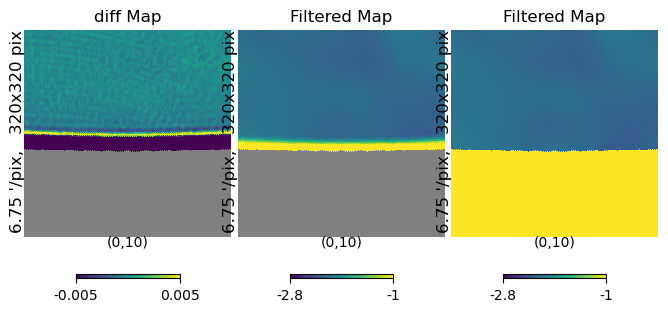

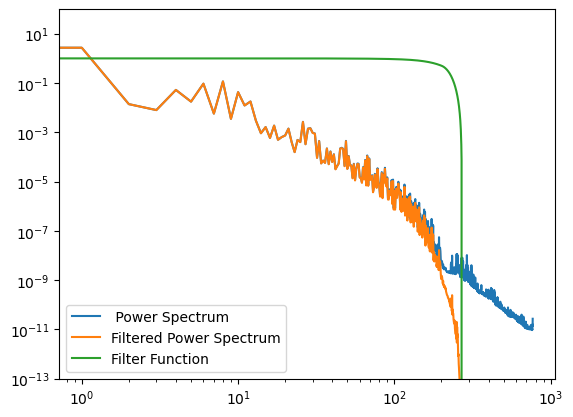

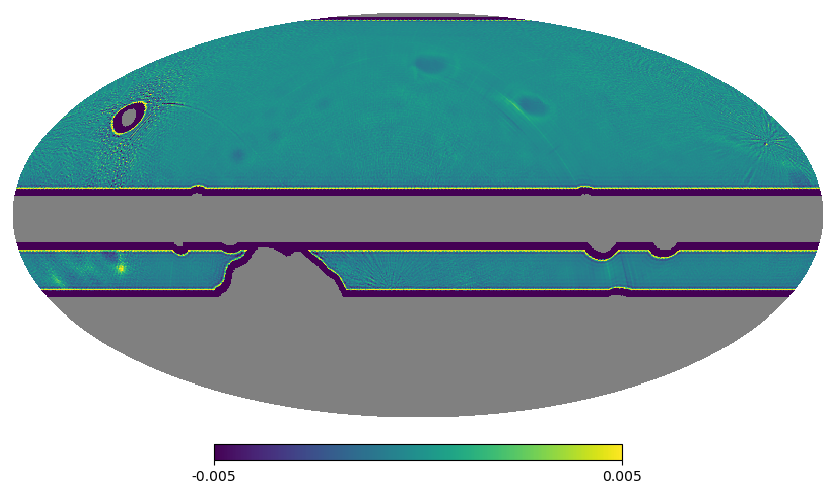

In [12]:
cl= hp.alm2cl(alm)  # Convert the filtered alm back to power spectrum
f0 = raised_cosine_filter(l_arr, l0=200, width=40, taper_width=70)
almf = hp.almxfl(alm,  f0)

clf= hp.alm2cl(almf)  # Convert the filtered alm back to power spectru
pl.figure() 
mapf =  (hp.alm2map(almf, nside) ) # Convert the filtered alm back to map
mapf[nans]=np.nan 
hp.gnomview(((mapf)- beta  )/beta ,   title='diff Map',  min=-.005,max=.005  ,reso=6.75,xsize= 320 ,rot=[0,10 ], sub=131 )
hp.gnomview(((mapf)  ) ,  title='Filtered Map',   min=-2.8,max=-1., reso=6.75,xsize= 320 ,rot=[0,10 ], sub=132 )
hp.gnomview(((beta)  ) ,  title='Filtered Map',   min=-2.8,max=-1., reso=6.75,xsize= 320 ,rot=[0,10 ], sub=133 )
pl.figure() 
pl.loglog(cl, label=' Power Spectrum') 
pl.loglog(clf, label='Filtered Power Spectrum') 
pl.loglog(f0, label='Filter Function')
pl.legend()
pl.ylim(1e-13,1e2)



hp.mollview(((mapf)- beta  )/beta  ,min=-.005,max=.005  , title='' )

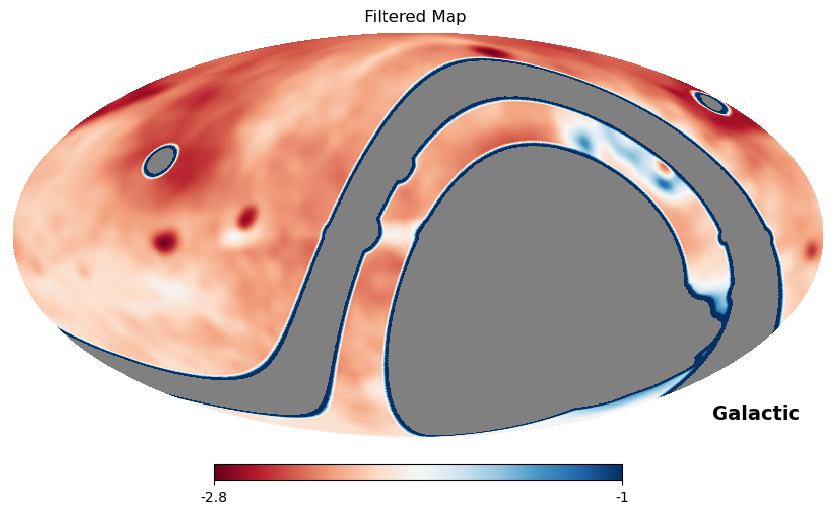

In [14]:
hp.mollview((mapf ) , min=-2.8,max=-1., cmap='RdBu' ,coord='CG',   title=' Filtered Map  ')


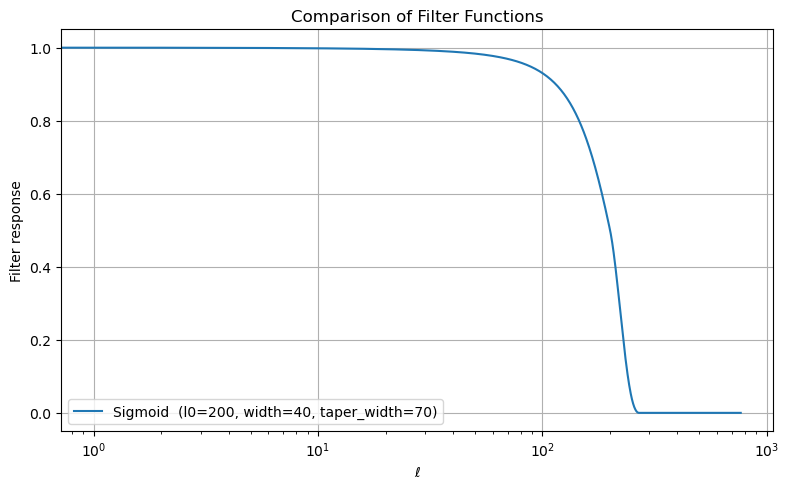

In [21]:

# Compare all filters used so far
pl.figure(figsize=(8,5))
pl.plot(l_arr, f0, label='Sigmoid  (l0=200, width=40, taper_width=70)') 
pl.semilogx () 
pl.xlabel(r'$\ell$')
pl.ylabel('Filter response')
pl.title('Comparison of Filter Functions')
pl.legend()
pl.grid(True)
pl.tight_layout()
pl.show()

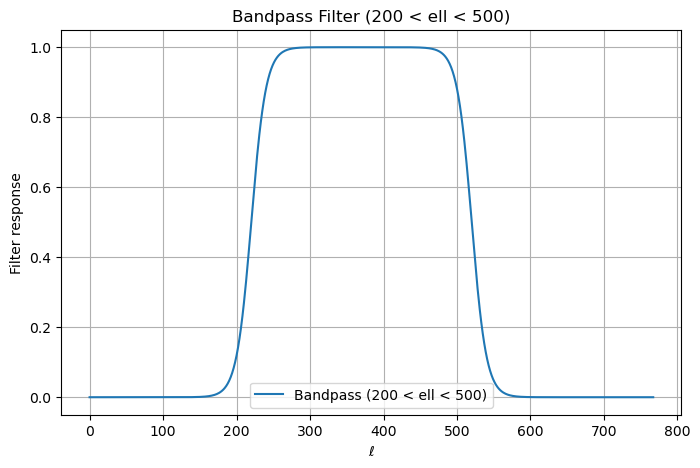

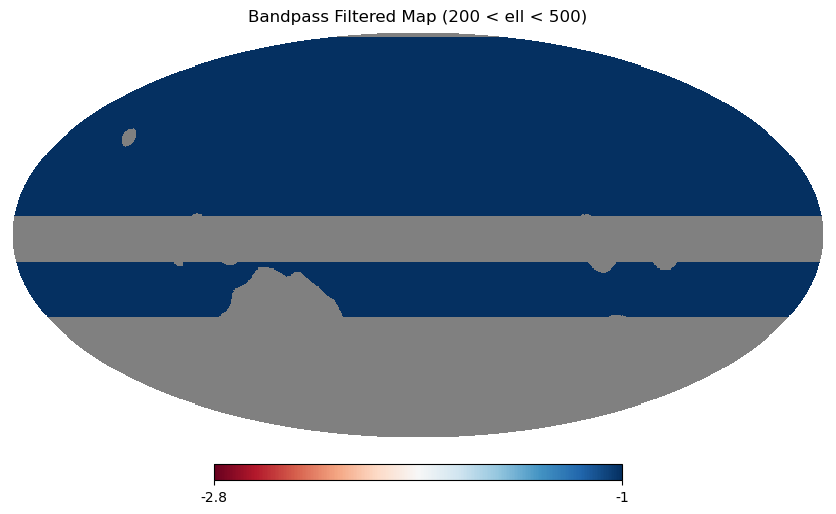

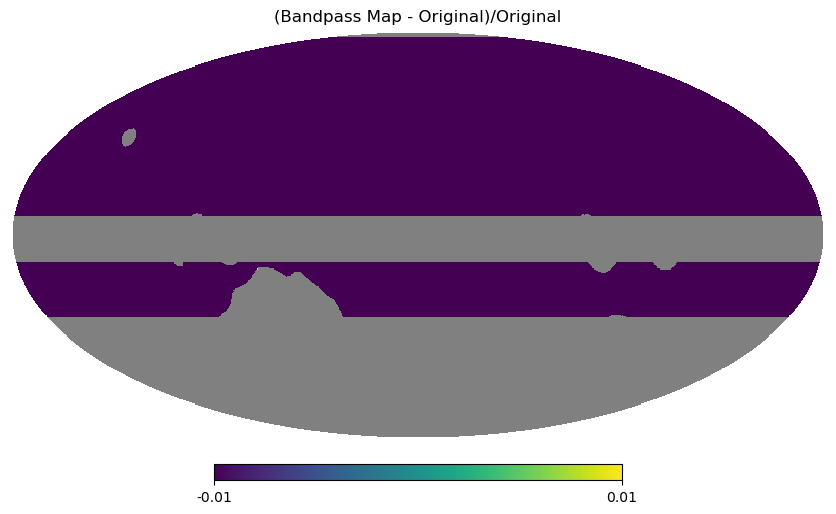

In [29]:
# Band-pass filter: smooth transitions at both edges to avoid ringing

def bandpass_filter(l, lmin, lmax, width=40):
    """Smooth bandpass filter between lmin and lmax with given width."""
    # Smoothly turn on at lmin
    low = sigmoid(l, lmin, width, power=4)
    # Smoothly turn off at lmax
    high = 1 - sigmoid(l, lmax, width, power=4)
    return low * high

# Create the bandpass filter for ell=200 to ell=500
f_band = bandpass_filter(l_arr, lmin=200, lmax=500, width=40)
almf_band = hp.almxfl(alm, f_band)
mapf_band = hp.alm2map(almf_band, nside)
mapf_band[nans] = np.nan

# Plot the filter and the resulting map
pl.figure(figsize=(8,5))
pl.plot(l_arr, f_band, label='Bandpass (200 < ell < 500)')
pl.xlabel(r'$\ell$')
pl.ylabel('Filter response')
pl.title('Bandpass Filter (200 < ell < 500)')
pl.legend()
pl.grid(True)
#pl.tight_layout()
pl.show()

hp.mollview(mapf_band, min=-2.8, max=-1., cmap='RdBu', title='Bandpass Filtered Map (200 < ell < 500)')
hp.mollview((mapf_band - beta)/beta, min=-.01, max=.01, title='(Bandpass Map - Original)/Original')

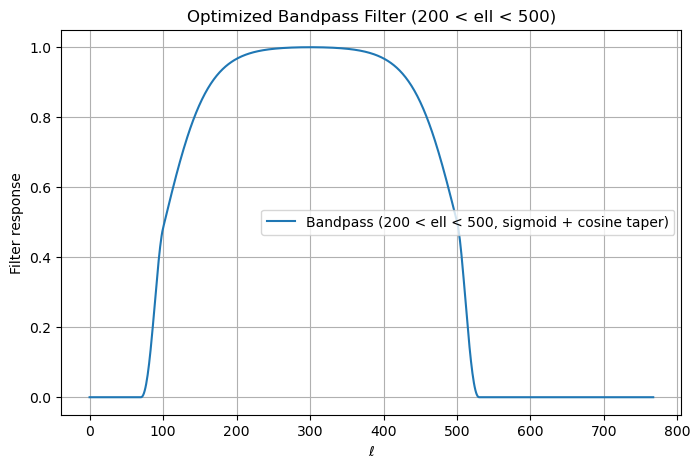

In [66]:


# Optimized bandpass filter using sigmoid_filter and cosine taper to minimize ringing

def bandpass_sigmoid_cosine(l, lmin, lmax, width=50, taper_width=60):
    """Bandpass filter using sigmoid_filter and cosine taper for smooth transitions."""
    # Smoothly turn on at lmin
    low = sigmoid_filter(l, l0=lmin, width=width)
    # Smoothly turn off at lmax
    high = 1 - sigmoid_filter(l, l0=lmax, width=width)
    band = low * high
    band = band / np.max(band)
    # Cosine taper at both edges
    taper = np.ones_like(l, dtype=float)
    # Taper below lmin
    idx_lo = l < lmin
    taper[idx_lo] = 0.5 * (1 + np.cos(np.pi * (lmin - l[idx_lo]) / taper_width))
    taper[l < lmin - taper_width] = 0
    # Taper above lmax
    idx_hi = l > lmax
    taper[idx_hi] = 0.5 * (1 + np.cos(np.pi * (l[idx_hi] - lmax) / taper_width))
    taper[l > lmax + taper_width] = 0
    return band * taper



# Apply the optimized bandpass filter for ell=200 to ell=500
f_band_opt = bandpass_sigmoid_cosine(l_arr, lmin=100, lmax=500, width=30, taper_width=30)
almf_band_opt = hp.almxfl(alm, f_band_opt)
mapf_band_opt = hp.alm2map(almf_band_opt, nside)
mapf_band_opt[nans] = np.nan

# Plot the filter and the resulting map
pl.figure(figsize=(8,5))
pl.plot(l_arr, f_band_opt, label='Bandpass (200 < ell < 500, sigmoid + cosine taper)')
pl.xlabel(r'$\ell$')
pl.ylabel('Filter response')
pl.title('Optimized Bandpass Filter (200 < ell < 500)')
pl.legend()
pl.grid(True)
 

/var/folders/5z/q8qtpx256193nq9w767m2mkw0000gn/T/ipykernel_17616/3362916902.py:5: RuntimeWarning: divide by zero encountered in power
  powerlaw = lambda l, A, alpha: A * l**alpha


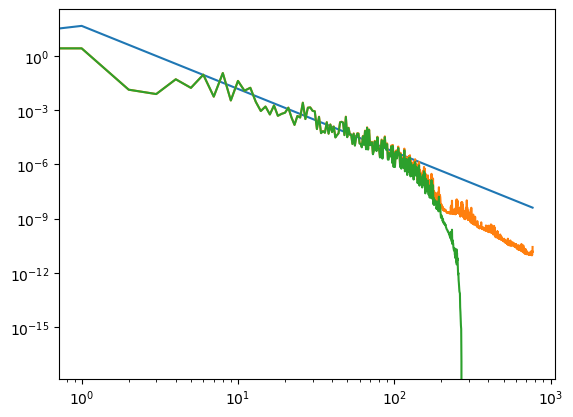

In [67]:
clpow = powerlaw(l_arr , *popt) 
clpow[0]=0.0 
pl.loglog(l_arr,clpow, label='Power Law Fit' )

pl.loglog(l_arr, cl, label='Original Power Spectrum' ) 
pl.loglog(l_arr, clf, label='Filtered Power Spectrum' )

[ 0.00000000e+00+0.00000000e+00j -1.73250816e+01+0.00000000e+00j
 -2.45506616e-01+0.00000000e+00j ...  1.30909653e-05-4.40642825e-05j
  1.38061249e-05+2.49607580e-05j -1.42957618e-05+2.30281088e-07j]


<Figure size 800x500 with 0 Axes>

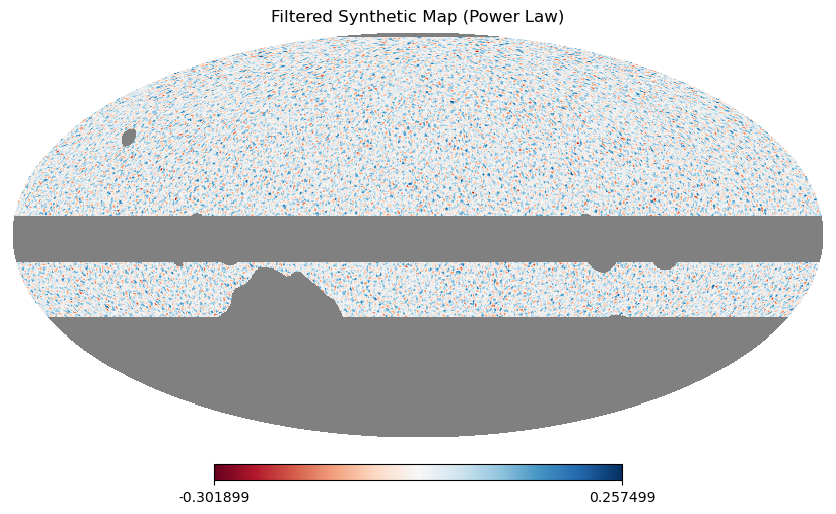

In [68]:

alm1 = hp.synalm(clpow, lmax=lmax, new=True)  # Generate synthetic alm from the fitted power law
print(alm1 )
almf1 = hp.almxfl(alm1, f_band_opt)  # Apply the optimized bandpass filter
mapf1 = hp.alm2map(almf1, nside)
mapf1[nans] = np.nan  # Mask invalid pixels
# Plot the filtered synthetic map
pl.figure(figsize=(8,5))
hp.mollview(mapf1,   cmap='RdBu', title='Filtered Synthetic Map (Power Law)')


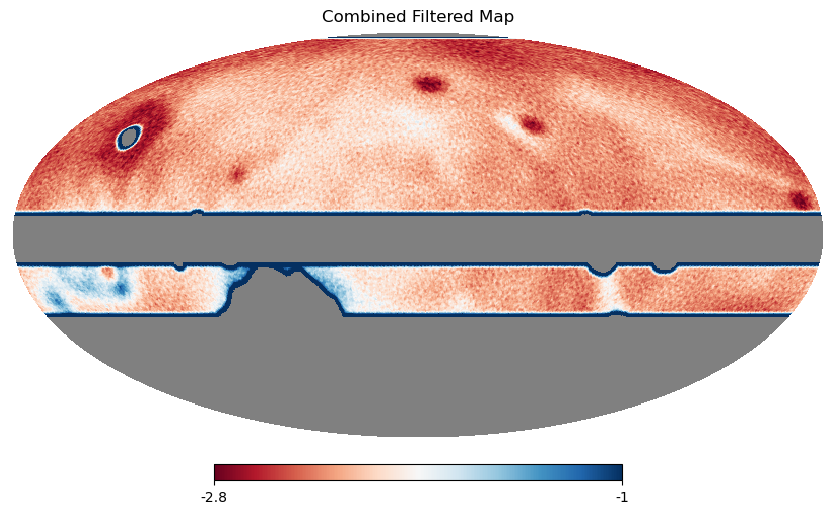

In [69]:
mapsum = mapf + apo*mapf1  # Combine the filtered maps
hp.mollview(mapsum, min=-2.8, max=-1., cmap='RdBu', title='Combined Filtered Map')
mapsum[nans] = 0.    # Mask invalid pixels 
clsum  =hp.anafast(mapsum , lmax=lmax )

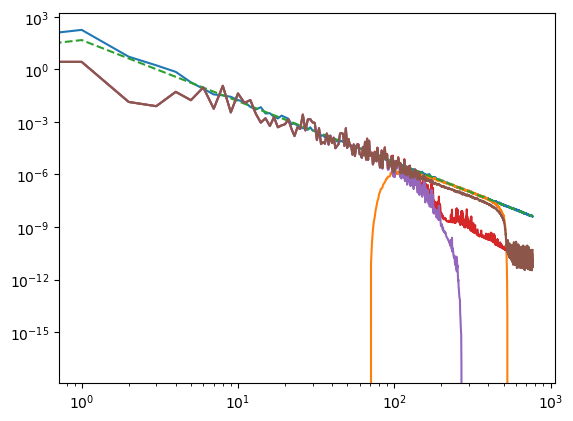

In [70]:
pl.loglog(l_arr, hp.alm2cl(alm1, lmax=lmax ), label='Optimized Bandpass Filter (200 < ell < 500)')
pl.loglog(l_arr, hp.alm2cl(almf1, lmax=lmax ), label='Optimized Bandpass Filter (200 < ell < 500)')
pl.loglog(l_arr,clpow, '--', label='Power Law Fit' )

pl.loglog(l_arr, cl, label='Original Power Spectrum' ) 
pl.loglog(l_arr, clf, label='Filtered Power Spectrum' )
pl.loglog(l_arr, clsum , label='Filtered Power Spectrum' )

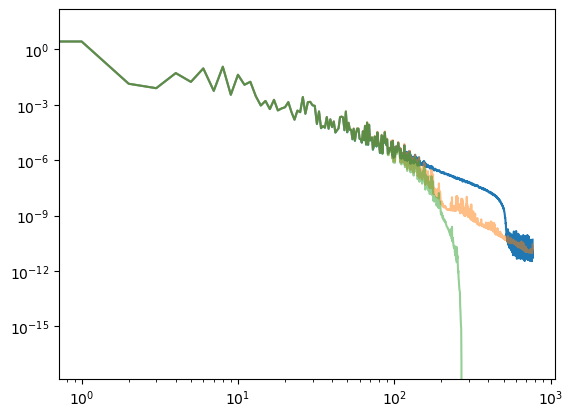

In [75]:
pl.loglog(l_arr, clsum , label='Filtered Power Spectrum' )
pl.loglog(l_arr, cl , label='Filtered Power Spectrum' , alpha=.5)
pl.loglog(l_arr, clf , label='Filtered Power Spectrum' , alpha=.5)

[]

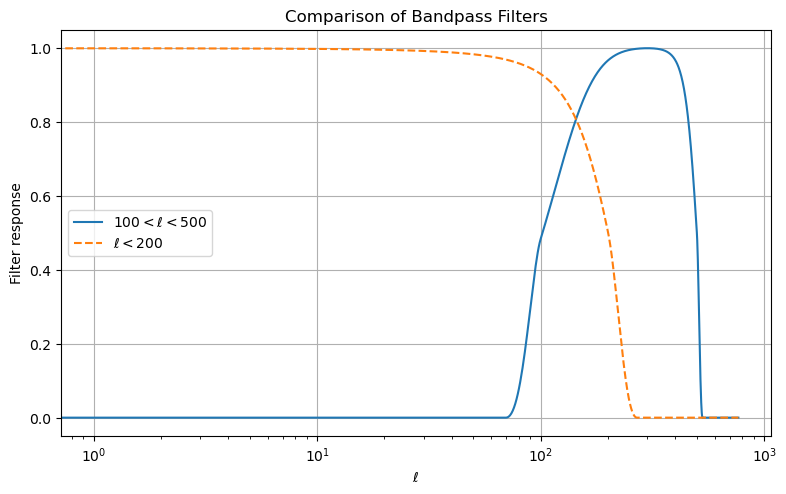

In [79]:
pl.figure(figsize=(8,5))
pl.plot(l_arr, f_band_opt, label=r'$100<\ell<500 $')
pl.plot(l_arr, f0,  label=r'$\ell<200 $', linestyle='--')
pl.xlabel(r'$\ell$')
pl.ylabel('Filter response')
pl.title('Comparison of Bandpass Filters')
pl.legend()
pl.grid(True)
pl.tight_layout()
pl.semilogx()